# An scalping strategy that uses EMA's and the Stochastic Oscillator 

In [267]:
import pandas as pd
import numpy as np
import tpqoa
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from datetime import datetime, timedelta

In [268]:
#get historical data
class Scalper(tpqoa.tpqoa):
    def __init__(self, config, instrument):
        super().__init__(config)
        self.instrument = instrument
        self.get_historical()
        self.results = None
        
    def get_historical(self):
        now = datetime.utcnow()
        now = now - timedelta(microseconds = now.microsecond)
        past = now - timedelta(days = 100)
        df = self.get_history(instrument = self.instrument, start = past, end = now,
                               granularity = "S30", price = "M").c.dropna().to_frame()
        df.rename(columns = {"c":self.instrument}, inplace = True)
        df.index = df.index.tz_localize("UTC")
        df = df.resample("1min", label = "right").last().dropna().iloc[:-1]
        df["EMA_50"] = df[self.instrument].ewm(span = 50, min_periods = 50).mean()
        df["EMA_100"] = df[self.instrument].ewm(span = 100, min_periods = 100).mean()
        df["Low_5"] = df[self.instrument].rolling(window = 5).min()
        df["High_5"] = df[self.instrument].rolling(window = 5).max()
        df["%K"] = 100*((df[self.instrument] - df["Low_5"]) / (df["High_5"] - df["Low_5"]))
        df["%D"] = df["%K"].rolling(window = 3).mean()
        df["%K_lag"] = df["%K"].shift()
        df["percent_diff"] = 100*(np.abs(df[self.instrument] - df["EMA_50"]) / ((df[self.instrument] + df["EMA_50"]) / 2))
        df = df.dropna()
        self.hist_data = df.copy()
        
    def test_strategy(self):
        raw = self.hist_data.copy()
        raw["returns"] = np.log(raw[self.instrument] / raw[self.instrument].shift())
        raw["EMA_position"] = np.where(raw["EMA_50"] > raw["EMA_100"], 1, 0)
        raw["EMA_position"] = np.where(raw["EMA_50"] < raw["EMA_100"], -1, raw["EMA_position"])
        raw["Stoch_position_long_1"] = np.where(raw["%K"] > 20, 1, 0)
        raw["Stoch_position_long_2"] = np.where(raw["%K"] < 80, 1, 0)
        raw["Stoch_position_long_3"] = np.where(raw["%K"] > raw["%D"], 1, 0)
        raw["Stoch_position_long"] = np.where(raw["Stoch_position_long_1"] + raw["Stoch_position_long_2"] + raw["Stoch_position_long_3"] == 3, 1, 0)
        raw["Stoch_position_short_1"] = np.where(raw["%K"] > 20, -1, 0)
        raw["Stoch_position_short_2"] = np.where(raw["%K"] < 80, -1, 0)
        raw["Stoch_position_short_3"] = np.where(raw["%K"] < raw["%D"], -1, 0)
        raw["Stoch_position_short"] = np.where(raw["Stoch_position_short_1"] + raw["Stoch_position_short_2"] + raw["Stoch_position_short_3"] == -3, -1, 0)
        raw["Stoch_lag_position"] = np.where(raw["%K_lag"] < 20, 1, 0)
        raw["Stoch_lag_position"] = np.where(raw["%K_lag"] > 80, -1, raw["Stoch_lag_position"])
        raw["percent_diff_long"] = np.where(raw["percent_diff"] < .01, 1, 0)
        raw["percent_diff_short"] = np.where(raw["percent_diff"] < .01, -1, raw["percent_diff_long"])
        raw["position"] = np.where(raw["EMA_position"] + raw["Stoch_position_long"] + raw["Stoch_lag_position"] + raw["percent_diff_long"] == 4, 1, 0)
        raw["position"] = np.where(raw["EMA_position"] + raw["Stoch_position_short"] + raw["Stoch_lag_position"] + raw["percent_diff_short"] == -4, -1, raw["position"])
        
        raw["strategy"] = raw["position"].shift(1) * raw["returns"]
        
        # determine when a trade takes place
        raw["trades"] = raw.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        raw.strategy = raw.strategy - raw.trades * .00005
        
        raw["creturns"] = raw["returns"].cumsum().apply(np.exp)
        raw["cstrategy"] = raw["strategy"].cumsum().apply(np.exp) 
        self.results = raw.copy()
        
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} ".format(self.instrument)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))

In [269]:
eur_usd = Scalper(r"C:\Users\btiv\Downloads\Part4_Materials\Part4_Materials\Oanda\oanda.cfg", "EUR_USD")

In [270]:
eur_usd.hist_data

,EUR_USD,EMA_50,EMA_100,Low_5,High_5,%K,%D,%K_lag,percent_diff
time,,,,,,,,,
2020-10-20 17:10:00+00:00,1.18310,1.182894,1.182815,1.18310,1.18319,0.000000,44.444444,53.333333,0.017455
2020-10-20 17:11:00+00:00,1.18323,1.182907,1.182825,1.18310,1.18323,100.000000,51.111111,0.000000,0.027307
2020-10-20 17:12:00+00:00,1.18320,1.182919,1.182833,1.18310,1.18323,76.923077,58.974359,100.000000,0.023783
2020-10-20 17:13:00+00:00,1.18327,1.182933,1.182843,1.18310,1.18327,100.000000,92.307692,76.923077,0.028515
2020-10-20 17:14:00+00:00,1.18316,1.182942,1.182850,1.18310,1.18327,35.294118,70.739065,100.000000,0.018453
...,...,...,...,...,...,...,...,...,...
2021-01-28 15:26:00+00:00,1.21373,1.213439,1.212838,1.21362,1.21400,28.947368,9.649123,0.000000,0.023973
2021-01-28 15:27:00+00:00,1.21379,1.213453,1.212857,1.21362,1.21390,60.714286,29.887218,28.947368,0.027782
2021-01-28 15:28:00+00:00,1.21387,1.213469,1.212877,1.21362,1.21387,100.000000,63.220551,60.714286,0.033025


In [271]:
eur_usd.test_strategy()

In [276]:
eur_usd.results

,EUR_USD,EMA_50,EMA_100,Low_5,High_5,%K,%D,%K_lag,percent_diff,returns,...,Stoch_position_short_3,Stoch_position_short,Stoch_lag_position,percent_diff_long,percent_diff_short,position,strategy,trades,creturns,cstrategy
time,,,,,,,,,,,,,,,,,,,,,
2020-10-20 17:10:00+00:00,1.18310,1.182894,1.182815,1.18310,1.18319,0.000000,44.444444,53.333333,0.017455,NaN,...,-1,0,0,0,0,0,NaN,0.0,NaN,NaN
2020-10-20 17:11:00+00:00,1.18323,1.182907,1.182825,1.18310,1.18323,100.000000,51.111111,0.000000,0.027307,0.000110,...,0,0,1,0,0,0,0.0,0.0,1.000110,1.000000
2020-10-20 17:12:00+00:00,1.18320,1.182919,1.182833,1.18310,1.18323,76.923077,58.974359,100.000000,0.023783,-0.000025,...,0,0,-1,0,0,0,-0.0,0.0,1.000085,1.000000
2020-10-20 17:13:00+00:00,1.18327,1.182933,1.182843,1.18310,1.18327,100.000000,92.307692,76.923077,0.028515,0.000059,...,0,0,0,0,0,0,0.0,0.0,1.000144,1.000000
2020-10-20 17:14:00+00:00,1.18316,1.182942,1.182850,1.18310,1.18327,35.294118,70.739065,100.000000,0.018453,-0.000093,...,-1,-1,-1,0,0,0,-0.0,0.0,1.000051,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-28 15:26:00+00:00,1.21373,1.213439,1.212838,1.21362,1.21400,28.947368,9.649123,0.000000,0.023973,0.000091,...,0,0,1,0,0,0,0.0,0.0,1.025890,0.698628
2021-01-28 15:27:00+00:00,1.21379,1.213453,1.212857,1.21362,1.21390,60.714286,29.887218,28.947368,0.027782,0.000049,...,0,0,0,0,0,0,0.0,0.0,1.025940,0.698628
2021-01-28 15:28:00+00:00,1.21387,1.213469,1.212877,1.21362,1.21387,100.000000,63.220551,60.714286,0.033025,0.000066,...,0,0,0,0,0,0,0.0,0.0,1.026008,0.698628


In [274]:
eur_usd.results.position.value_counts()

 0    95358
 1     1662
-1     1349
Name: position, dtype: int64

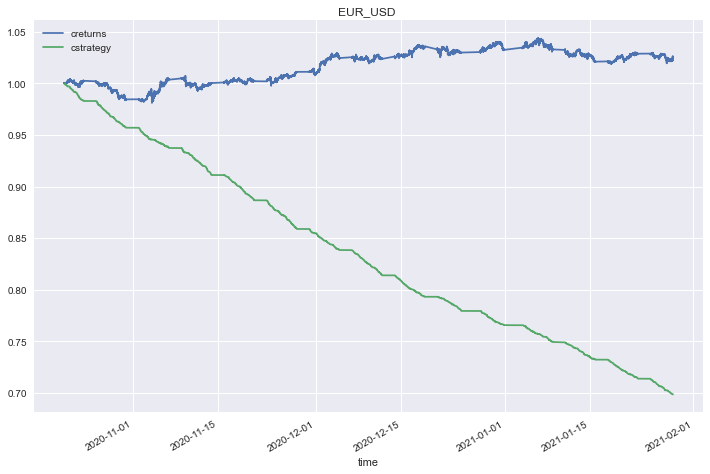

In [275]:
eur_usd.plot_results()